In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
CUDA = torch.cuda.is_available()

In [6]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [7]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [8]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [9]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [11]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [12]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [13]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [14]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)
    

In [15]:
class RecDecoderHead(nn.Module):
    def __init__(self):
        super(RecDecoderHead, self).__init__()
        self.fc = nn.Linear(1, 128)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderBody(nn.Module):
    def __init__(self):
        super(RecDecoderBody, self).__init__()
        self.fc = nn.Linear(129, 128) # prev state + hidden
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderTail(nn.Module):  
    def __init__(self):
        super(RecDecoderTail, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)      
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        o = h3.view(-1,784)
        return F.sigmoid(o)    

In [16]:
E = Encoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]
D_head = RecDecoderHead()
D_body = [RecDecoderBody() for _ in range(N-1)]
D_tail = RecDecoderTail()

In [17]:
if CUDA:
    E.cuda()
    O0.cuda()
    [e.cuda() for e in Os]
    [e.cuda() for e in Ts]
    [e.cuda() for e in T1s]
    [e.cuda() for e in Gs]
    D_head.cuda()
    [e.cuda() for e in D_body]
    D_tail.cuda()

In [18]:
import os
os.system('mkdir -p checkpoint_recdecoder')
PATH = 'checkpoint_recdecoder/hd_vae'
def save_model():
    torch.save(E.state_dict(), "{}_E".format(PATH))
    torch.save(O0.state_dict(), "{}_O0".format(PATH))
    
    def save_list(models, name):
        for i in range(len(models)):
            torch.save(models[i].state_dict(), "{}_{}_{}".format(PATH, name, i))
    
    save_list(Os, 'Os')
    save_list(Ts, 'Ts')
    save_list(T1s, 'T1s')
    save_list(Gs, 'Gs')
    
    torch.save(D_head.state_dict(), "{}_D_head".format(PATH))
    save_list(D_body, 'D_body')
    torch.save(D_tail.state_dict(), "{}_D_tail".format(PATH))
    
#save_model()

In [19]:
from itertools import product
    
log_two_pow_n = Variable(torch.Tensor([2**N]).log(), requires_grad=False)
if CUDA:
    log_two_pow_n = log_two_pow_n.cuda()

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
        sofar = E(x)
        outputs = [O0(sofar)]

        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](path[n]) # Kind of doing "teacher forcing"
            outputs.append(Os[n](sofar))

        q = prob(outputs)

        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([x.shape[0]]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_n + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [20]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-03 *
  1.6995
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [21]:
x

Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 4x784 (GPU 0)]

In [22]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)/bsize # TODO eddie: changed from size_average=False
    # Assuming independent latent
#     KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x)
    return BCE, KLD

In [23]:
params = [
    {'params':E.parameters()},
    {'params':O0.parameters()} 
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] \
  + [{'params': g.parameters()} for g in Gs] \
  + [{'params': D_head.parameters()}, {'params': D_tail.parameters()}] \
  + [{'params': d_body.parameters()} for d_body in D_body]
optimizer = optim.Adam(params, lr=1e-4)

In [24]:
best_loss_sofar = 9999

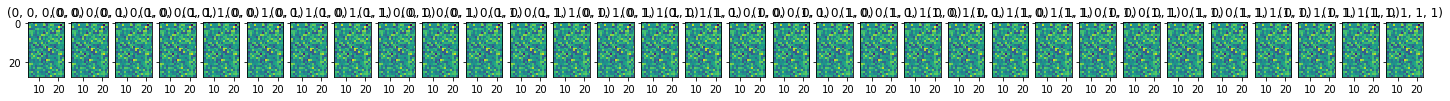

In [25]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        t = t.unsqueeze(0)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        decoder_hidden = D_head(make_variable(path[0]))
        for n in range(1, len(path)):
            decoder_hidden_inp = torch.cat([decoder_hidden, make_variable(path[n])], -1)
            decoder_hidden = D_body[n-1](decoder_hidden_inp)
        w = D_tail(decoder_hidden)

        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()
    
debug()

In [26]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        samples = [sample(outputs[-1])]
        decoder_hidden = D_head(samples[-1])
        # TODO unroll this may make it faster
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](samples[-1])
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
            
            decoder_hidden_inp = torch.cat([decoder_hidden, samples[-1]], -1)
            decoder_hidden = D_body[n](decoder_hidden_inp)
            
        recon_x = D_tail(decoder_hidden)
     
        bits = torch.cat(samples, dim=1) # for debugging only
        q = prob(outputs)

        BCE, KLD = loss_function(recon_x, x, q)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
#         if batch_idx % 200 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 BCE.data[0] / len(data),
#                 KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
        save_model()
        best_loss_sofar = avg_loss
        debug()
        
    return q, bits # debugging

====> Epoch: 1 Average BCE loss: 2.3925, Average KLD loss: 0.0065, Total: 2.3990
Loss 2.398972283206564 is better than previous best 9999, saving model


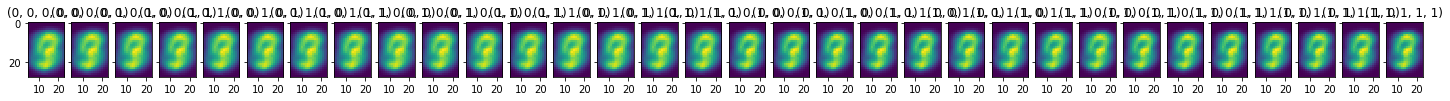

====> Epoch: 2 Average BCE loss: 2.0208, Average KLD loss: 0.0071, Total: 2.0279
Loss 2.027891278920571 is better than previous best 2.398972283206564, saving model


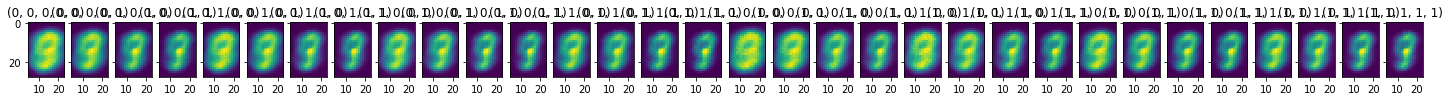

====> Epoch: 3 Average BCE loss: 1.9223, Average KLD loss: 0.0072, Total: 1.9295
Loss 1.9294730318625768 is better than previous best 2.027891278920571, saving model


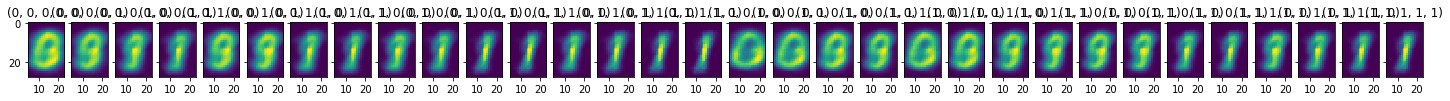

====> Epoch: 4 Average BCE loss: 1.8829, Average KLD loss: 0.0075, Total: 1.8904
Loss 1.8904221292058625 is better than previous best 1.9294730318625768, saving model


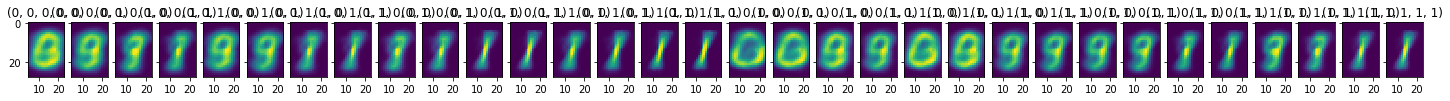

====> Epoch: 5 Average BCE loss: 1.8710, Average KLD loss: 0.0076, Total: 1.8786
Loss 1.8785948663850625 is better than previous best 1.8904221292058625, saving model


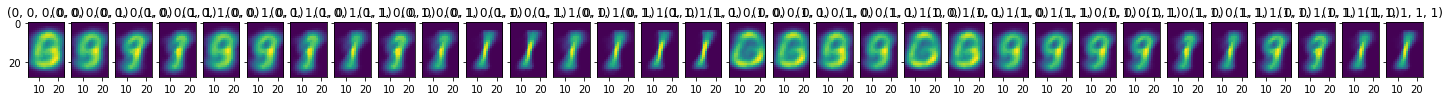

====> Epoch: 6 Average BCE loss: 1.8637, Average KLD loss: 0.0073, Total: 1.8710
Loss 1.8710426353365182 is better than previous best 1.8785948663850625, saving model


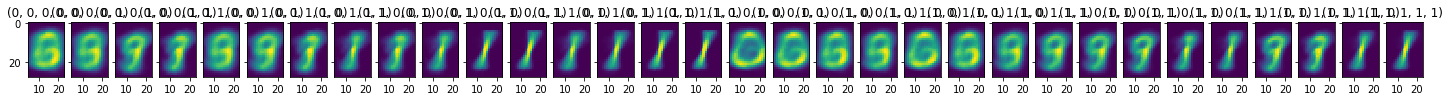

====> Epoch: 7 Average BCE loss: 1.8558, Average KLD loss: 0.0074, Total: 1.8632
Loss 1.863178355957071 is better than previous best 1.8710426353365182, saving model


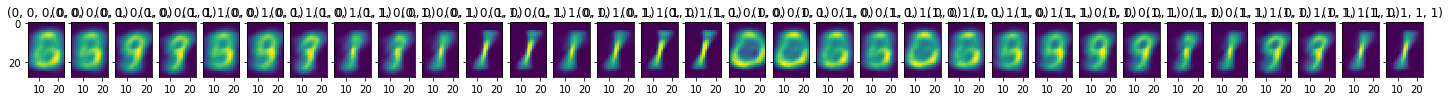

====> Epoch: 8 Average BCE loss: 1.8502, Average KLD loss: 0.0074, Total: 1.8576
Loss 1.8575995478769143 is better than previous best 1.863178355957071, saving model


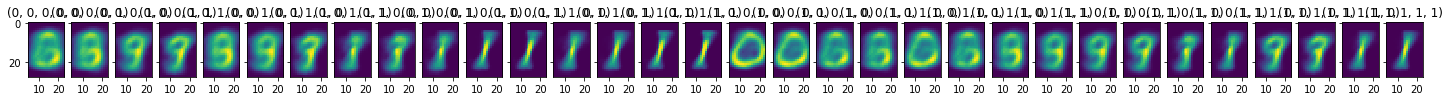

====> Epoch: 9 Average BCE loss: 1.8438, Average KLD loss: 0.0078, Total: 1.8516
Loss 1.8516052693933247 is better than previous best 1.8575995478769143, saving model


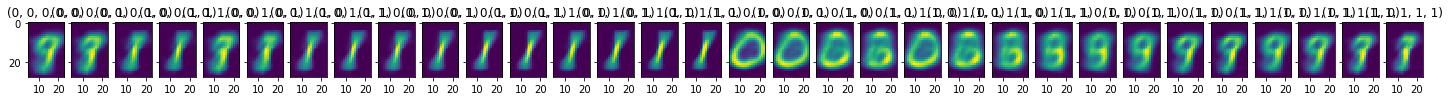

====> Epoch: 10 Average BCE loss: 1.8281, Average KLD loss: 0.0113, Total: 1.8394
Loss 1.8394212015052636 is better than previous best 1.8516052693933247, saving model


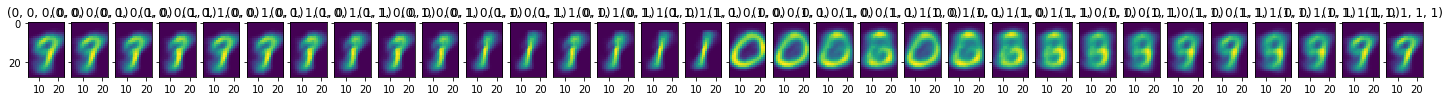

====> Epoch: 11 Average BCE loss: 1.8132, Average KLD loss: 0.0116, Total: 1.8248
Loss 1.8247597364226977 is better than previous best 1.8394212015052636, saving model


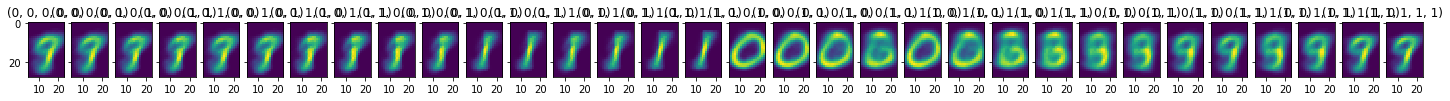

====> Epoch: 12 Average BCE loss: 1.8059, Average KLD loss: 0.0118, Total: 1.8177
Loss 1.8176632680356501 is better than previous best 1.8247597364226977, saving model


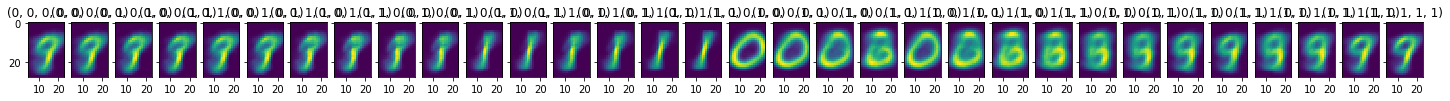

====> Epoch: 13 Average BCE loss: 1.8005, Average KLD loss: 0.0119, Total: 1.8124
Loss 1.81242764476339 is better than previous best 1.8176632680356501, saving model


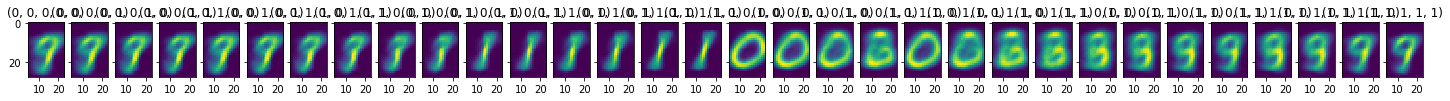

====> Epoch: 14 Average BCE loss: 1.7986, Average KLD loss: 0.0115, Total: 1.8101
Loss 1.810108868947625 is better than previous best 1.81242764476339, saving model


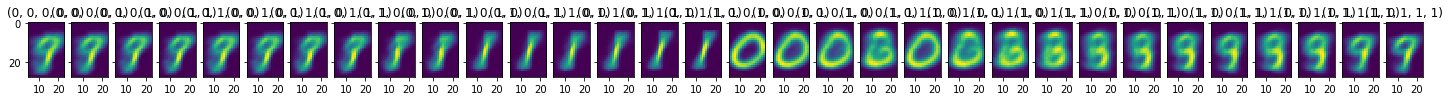

====> Epoch: 15 Average BCE loss: 1.7966, Average KLD loss: 0.0115, Total: 1.8081
Loss 1.8081202136695385 is better than previous best 1.810108868947625, saving model


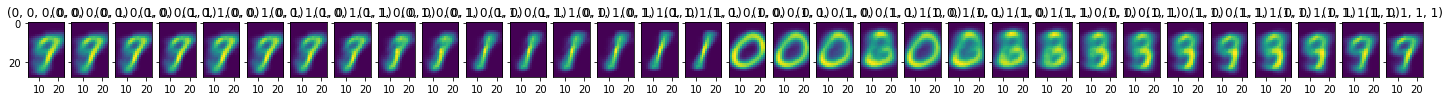

====> Epoch: 16 Average BCE loss: 1.7928, Average KLD loss: 0.0118, Total: 1.8046
Loss 1.8046021709700426 is better than previous best 1.8081202136695385, saving model


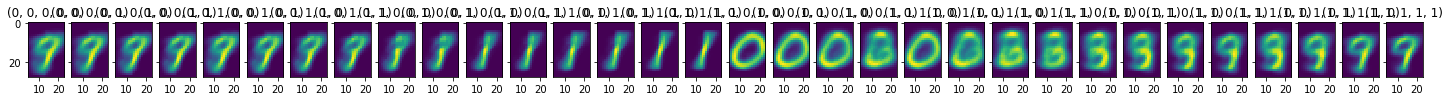

====> Epoch: 17 Average BCE loss: 1.7906, Average KLD loss: 0.0120, Total: 1.8026
Loss 1.8026416217048962 is better than previous best 1.8046021709700426, saving model


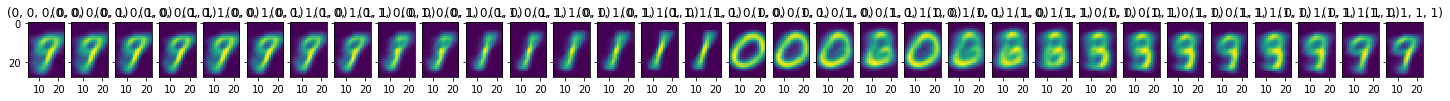

====> Epoch: 18 Average BCE loss: 1.7871, Average KLD loss: 0.0123, Total: 1.7993
Loss 1.7993122682601215 is better than previous best 1.8026416217048962, saving model


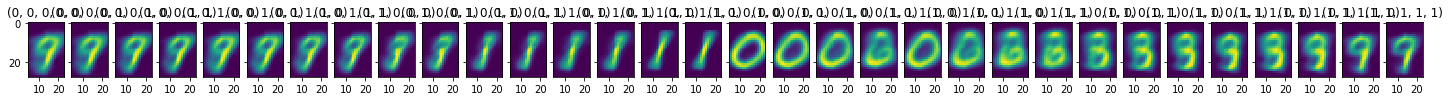

====> Epoch: 19 Average BCE loss: 1.7839, Average KLD loss: 0.0124, Total: 1.7963
Loss 1.7963236216843128 is better than previous best 1.7993122682601215, saving model


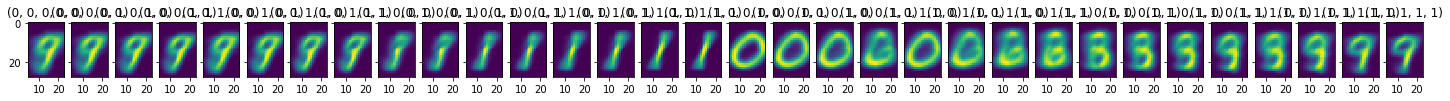

====> Epoch: 20 Average BCE loss: 1.7809, Average KLD loss: 0.0124, Total: 1.7933
Loss 1.793328445269664 is better than previous best 1.7963236216843128, saving model


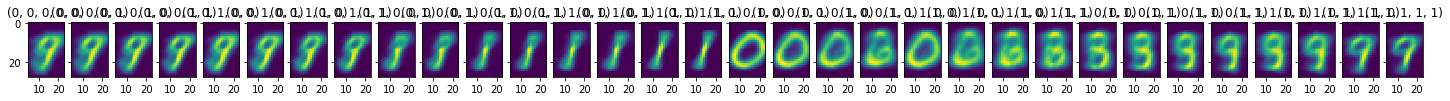

====> Epoch: 21 Average BCE loss: 1.7781, Average KLD loss: 0.0124, Total: 1.7905
Loss 1.7905422405719755 is better than previous best 1.793328445269664, saving model


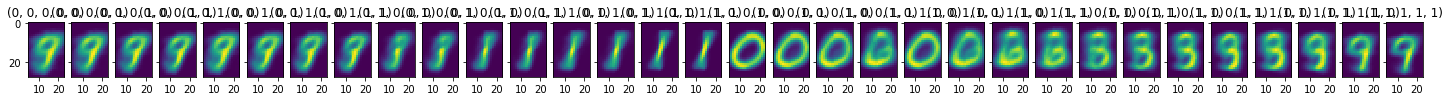

====> Epoch: 22 Average BCE loss: 1.7746, Average KLD loss: 0.0127, Total: 1.7873
Loss 1.787306963310639 is better than previous best 1.7905422405719755, saving model


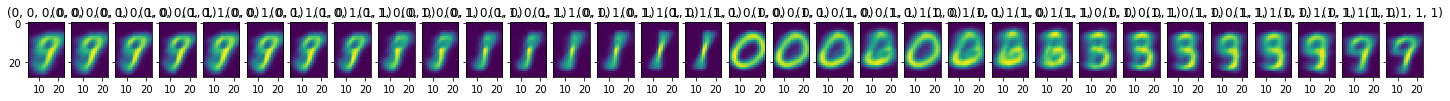

====> Epoch: 23 Average BCE loss: 1.7737, Average KLD loss: 0.0124, Total: 1.7861
Loss 1.7861036587973436 is better than previous best 1.787306963310639, saving model


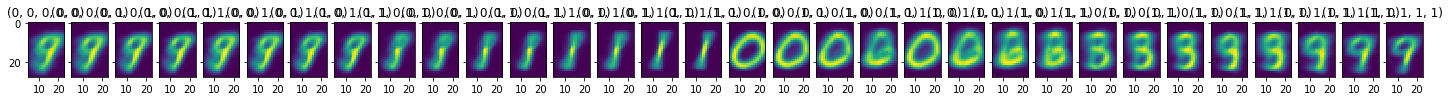

====> Epoch: 24 Average BCE loss: 1.7719, Average KLD loss: 0.0130, Total: 1.7849
Loss 1.7848909465789795 is better than previous best 1.7861036587973436, saving model


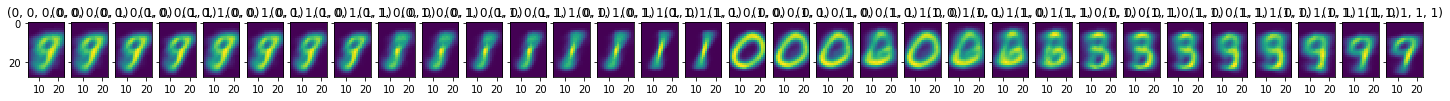

====> Epoch: 25 Average BCE loss: 1.7709, Average KLD loss: 0.0128, Total: 1.7836
Loss 1.7836153616964818 is better than previous best 1.7848909465789795, saving model


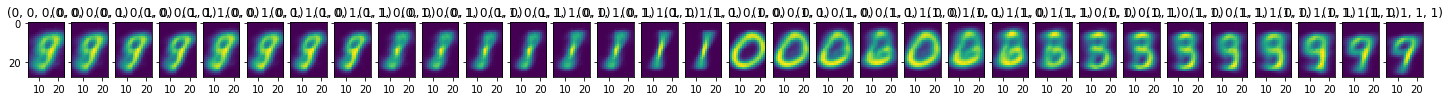

====> Epoch: 26 Average BCE loss: 1.7712, Average KLD loss: 0.0128, Total: 1.7841
====> Epoch: 27 Average BCE loss: 1.7724, Average KLD loss: 0.0125, Total: 1.7848
====> Epoch: 28 Average BCE loss: 1.7657, Average KLD loss: 0.0119, Total: 1.7776
Loss 1.7775896319180726 is better than previous best 1.7836153616964818, saving model


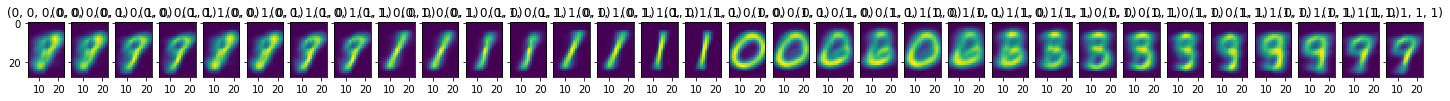

====> Epoch: 29 Average BCE loss: 1.7699, Average KLD loss: 0.0113, Total: 1.7812
====> Epoch: 30 Average BCE loss: 1.7654, Average KLD loss: 0.0113, Total: 1.7767
Loss 1.7766969392389058 is better than previous best 1.7775896319180726, saving model


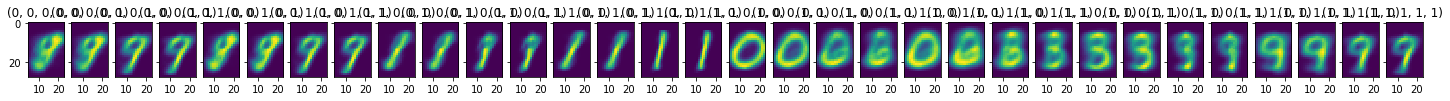

====> Epoch: 31 Average BCE loss: 1.7667, Average KLD loss: 0.0114, Total: 1.7781
====> Epoch: 32 Average BCE loss: 1.7656, Average KLD loss: 0.0114, Total: 1.7771
====> Epoch: 33 Average BCE loss: 1.7602, Average KLD loss: 0.0115, Total: 1.7717
Loss 1.771663518988093 is better than previous best 1.7766969392389058, saving model


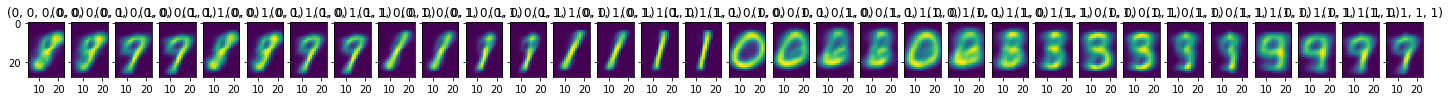

====> Epoch: 34 Average BCE loss: 1.7619, Average KLD loss: 0.0112, Total: 1.7731
====> Epoch: 35 Average BCE loss: 1.7568, Average KLD loss: 0.0114, Total: 1.7682
Loss 1.7682238319476447 is better than previous best 1.771663518988093, saving model


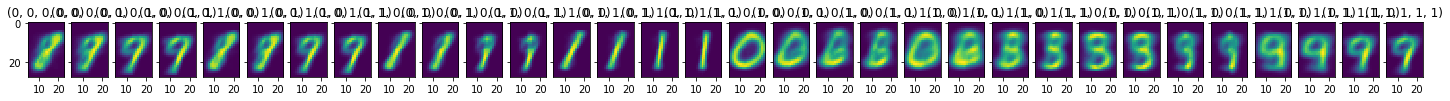

====> Epoch: 36 Average BCE loss: 1.7512, Average KLD loss: 0.0116, Total: 1.7628
Loss 1.7627591003547112 is better than previous best 1.7682238319476447, saving model


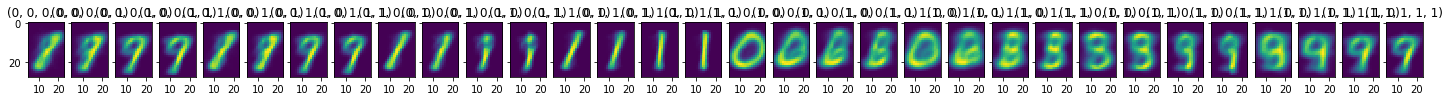

====> Epoch: 37 Average BCE loss: 1.7468, Average KLD loss: 0.0119, Total: 1.7588
Loss 1.7587731733004253 is better than previous best 1.7627591003547112, saving model


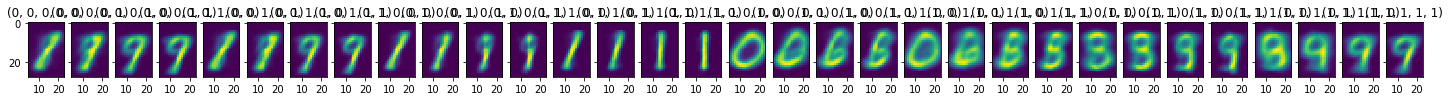

====> Epoch: 38 Average BCE loss: 1.7465, Average KLD loss: 0.0117, Total: 1.7582
Loss 1.7581783071001371 is better than previous best 1.7587731733004253, saving model


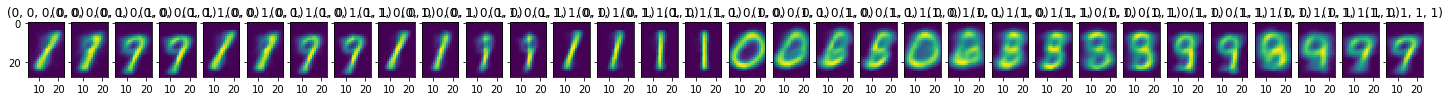

====> Epoch: 39 Average BCE loss: 1.7504, Average KLD loss: 0.0115, Total: 1.7619
====> Epoch: 40 Average BCE loss: 1.7770, Average KLD loss: 0.0102, Total: 1.7872
====> Epoch: 41 Average BCE loss: 1.8173, Average KLD loss: 0.0089, Total: 1.8262
====> Epoch: 42 Average BCE loss: 1.8096, Average KLD loss: 0.0089, Total: 1.8185
====> Epoch: 43 Average BCE loss: 1.7569, Average KLD loss: 0.0110, Total: 1.7680
====> Epoch: 44 Average BCE loss: 1.7504, Average KLD loss: 0.0113, Total: 1.7617
====> Epoch: 45 Average BCE loss: 1.7500, Average KLD loss: 0.0113, Total: 1.7612
====> Epoch: 46 Average BCE loss: 1.7489, Average KLD loss: 0.0113, Total: 1.7602
====> Epoch: 47 Average BCE loss: 1.7533, Average KLD loss: 0.0110, Total: 1.7643
====> Epoch: 48 Average BCE loss: 1.7546, Average KLD loss: 0.0111, Total: 1.7657
====> Epoch: 49 Average BCE loss: 1.7559, Average KLD loss: 0.0110, Total: 1.7669
====> Epoch: 50 Average BCE loss: 1.7525, Average KLD loss: 0.0109, Total: 1.7634
====> Epoch: 51 

In [27]:
%%time
for epoch in range(100):
    q, bits = train(epoch)

In [28]:
q

Variable containing:
( 0 ,.,.) = 
  1.0000e+00  2.9886e-11
  4.5691e-04  9.9954e-01
  9.9990e-01  9.8258e-05
  4.7400e-08  1.0000e+00
  4.4518e-01  5.5482e-01

( 1 ,.,.) = 
  1.0000e+00  8.8651e-14
  1.6217e-03  9.9838e-01
  9.9999e-01  5.2026e-06
  1.3970e-08  1.0000e+00
  5.0000e-01  5.0000e-01

( 2 ,.,.) = 
  1.0000e+00  6.3210e-08
  1.5300e-03  9.9847e-01
  9.0505e-01  9.4953e-02
  2.9849e-05  9.9997e-01
  5.0000e-01  5.0000e-01
... 

(97 ,.,.) = 
  1.0000e+00  9.2222e-16
  3.7653e-07  1.0000e+00
  5.0000e-01  5.0000e-01
  7.7240e-11  1.0000e+00
  2.8021e-03  9.9720e-01

(98 ,.,.) = 
  2.1245e-01  7.8755e-01
  5.8848e-01  4.1152e-01
  9.9948e-01  5.2490e-04
  3.7940e-04  9.9962e-01
  1.0150e-02  9.8985e-01

(99 ,.,.) = 
  1.0000e+00  1.6481e-17
  5.1857e-06  9.9999e-01
  1.0000e+00  5.3553e-07
  2.6385e-16  1.0000e+00
  2.8627e-05  9.9997e-01
[torch.cuda.FloatTensor of size 100x5x2 (GPU 0)]

In [29]:
bits

Variable containing:
    1     0     1     0     0
    1     0     1     0     1
    1     0     1     0     1
    1     0     0     1     0
    1     0     1     0     1
    1     0     0     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     1
    1     0     1     0     1
    1     0     0     0     1
    1     0     0     0     0
    1     0     0     0     1
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     1  